In [3]:
pip install seaborn --user

  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
from os.path import dirname, abspath
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from config import config_variables
print(config_variables)

{'PIPELINE_SWITCH': {'PIPELINE_TEST': False}, 'FEATURE_SET_VARS': {'IMPUTATION': 'Linear', 'MIN_THRESHOLD': 5}, 'FOLDERS': {'DATA': 'data', 'RAW_FEATURESET': 'raw_featureset', 'TEMPORAL': 'temporal_data', 'POST_PROCESSED_FEATURESET': 'post_processed_featureset'}, 'FEATURE_SET': {'RAW_FEATURESET_EXCEL': 'Datos.xlsx', 'SPLIT_LABEL_NAME': 'HeartDisease', 'FEATURESET_EXCEL': 'Data_featureset.xlsx', 'LABELS_EXCEL': 'Data_labelset.xlsx', 'POST_PROCESSED_EXCEL': 'Post_processed_data_featureset.xlsx', 'POSTPROCESSING_STEPS': {'DATA_IMPUTATION': True}}}


In [3]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [4]:
class HeartDataFile(object):
    def __init__(self, config_variables):
        self.config = config_variables
        self.base_path = (abspath(os.getcwd()))

        self.data_folder = config_variables['FOLDERS']['DATA']
        self.raw_data_folder = config_variables['FOLDERS']['RAW_FEATURESET']
        self.raw_excel_file = config_variables['FEATURE_SET']['RAW_FEATURESET_EXCEL']
        self.path_input_excel = os.path.join(self.base_path, self.data_folder, self.raw_data_folder, self.raw_excel_file)
        self.raw_heart_df = pd.read_excel(self.path_input_excel)

        self.temporal_data_folder = config_variables['FOLDERS']['TEMPORAL']
        self.label_name = config_variables['FEATURE_SET']['SPLIT_LABEL_NAME']
        self.target_name = config_variables['FEATURE_SET']['SPLIT_LABEL_NAME']

        self.feature_file = config_variables['FEATURE_SET']['FEATURESET_EXCEL']
        self.output_feature_file = os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.feature_file)
        self.features = pd.read_excel(self.output_feature_file)
    
  
        self.label_file = config_variables['FEATURE_SET']['LABELS_EXCEL']
        self.output_label_file = os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.label_file)
        
        self.post_data_folder = config_variables['FOLDERS']['POST_PROCESSED_FEATURESET']
        self.post_processed_featureset_excel_file = config_variables['FEATURE_SET']['POST_PROCESSED_EXCEL']
        self.path_output_excel = os.path.join(self.base_path, self.data_folder, self.post_data_folder, self.post_processed_featureset_excel_file)
    
    def split_labels_target(self, config_variables):
         #Check if folder exists
        if os.path.exists(os.path.join(self.base_path, self.data_folder, self.temporal_data_folder)) == False:
            #Create folder
            os.mkdir(os.path.join(self.base_path, self.data_folder, self.temporal_data_folder))
        else:
             print('Folder already exists')
        
        #Check if featureset file exists 
        if os.path.exists(os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.output_feature_file)) == True:
            print('Feature set file already exists')

        #Check if label file exists 
        if os.path.exists(os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.output_label_file)) == True:
            print('Label set file already exists')

        #Split labels
        
        self.feature_set = self.raw_heart_df.loc[:, self.raw_heart_df.columns != self.label_name]
        self.feature_df = self.feature_set.to_excel(self.output_feature_file)
        
        #Split target 
        
        self.label_set = self.raw_heart_df[self.label_name]
        self.label_df = self.label_set.to_excel(self.output_label_file)

    def visualization_num(self, config_variables):

        self.feature_excel = os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.features)
        self.feature_heart_df = pd.read_excel(self.feature_excel)
        #print(self.feature_heart_df)

        #Define numerical variables of dataframe 
        numeric = self.feature_heart_df.select_dtypes(include=[np.number])
        #Delete first column that is number of patients
        numeric_heart  = numeric.iloc[: , 1:]
        #print(numeric_heart)

        #Make correlation heatmap for numerical features
        #Correlation map is not displayed 
        #corr = numeric_heart.corr()
        #corr.style.background_gradient(cmap='coolwarm')
        #plt.show()

        # Get seaborn plot 1
        plt.figure(figsize=(16, 6))
        heatmap = sns.heatmap(numeric_heart.corr(),  cmap = 'coolwarm', vmin=-1, vmax=1, annot=True)

        heatmap.set_title('Correlation plot', fontdict={'fontsize':12}, pad=12)

        #output_file_name = self.plot_1_file.format(var = self.nba_success_var,  number = split)
        #path_to_output_plot = os.path.join(self.top_path, self.data_folder, self.correlation_folder, self.success_var_folder, output_file_name)
        #

        plt.savefig('plot.png', bbox_inches='tight')
        plt.show()


        #Make boxplot for numerical features 
        red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
        fig, axs = plt.subplots(1, len(numeric_heart.columns), figsize=(20,10))
        for i, ax in enumerate(axs.flat):
            ax.boxplot(numeric_heart.iloc[:,i], flierprops=red_circle)
            ax.set_title(numeric_heart.columns[i], fontsize=20, fontweight='bold')
            ax.tick_params(axis='y', labelsize=14)
            plt.tight_layout()

        
        #Save it in a specific path 
        plt.savefig('boxplot.png')

    def visualization_cat(self, config_variables):
        self.feature_excel = os.path.join(self.base_path, self.data_folder, self.temporal_data_folder, self.feature_file)
        self.feature_heart_df = pd.read_excel(self.feature_excel)
        
        #print(categorical_heart)

        #Extract columns names of categorical columns
        #for col in categorical_heart:
        #    print(col)


        categorical_heart = self.feature_heart_df.select_dtypes(exclude=[np.number])
        for categorical_columns in categorical_heart.columns.to_list():
            plt.figure()
            sns.countplot(y=categorical_columns, data=categorical_heart, palette="husl")
            plt.show()
              

    def data_imputation(self, df):


        #Separate numeric variables 
        integer_features = df.select_dtypes(exclude="object").columns
        #print(self.integer_features)

        #Separate categorical variables 
        categorical_features = df.select_dtypes(include="object").columns
        #print(self.categorical_features)

        #Delete outliers
        #self.feature_heart_df.boxplot(self.integer_features)

        #Define num_pipeline
        #Standarization 
        num_pipeline = Pipeline([
               ('std_scaler', StandardScaler()),
        ])



        #Normalization
        num_pipeline = Pipeline([
               ('scaler', MinMaxScaler()),
        ])

        
        #Apply One Hot Encoding
        full_pipeline = ColumnTransformer([
            ("num", num_pipeline, integer_features),
            ("cat", OneHotEncoder(), categorical_features),
        ])

        heart_prepared = full_pipeline.fit_transform(df)
        #print(heart_prepared)

        names = get_feature_names(full_pipeline)
        #print(names)

        #Delete first column 
        features = pd.DataFrame(heart_prepared,columns=names)
        features_final  = features.iloc[: , 1:]
        return features_final 
        #print(features_final)
 
    def build_featureset_definitive(self):
        #Check if featureset exists
        if os.path.exists(self.path_output_excel) == False:
            #Check if folder exists
            if os.path.exists(os.path.join(self.base_path, self.data_folder, self.post_data_folder)) == False:
                #Create folder
                os.mkdir(os.path.join(self.base_path, self.data_folder, self.post_data_folder))
            
            #Load input featureset
            inputdata_df = self.feature_heart_df
            
            #Preprocessing steps
            if self.config['FEATURE_SET']['POSTPROCESSING_STEPS']['DATA_IMPUTATION']:
                inputdata_df = self.data_imputation(inputdata_df)

            #Save postprocessed featureset 
            #inputdata_df.to_excel(self.path_output_excel)

        else: 
            print('No need to build featureset, file already exists')

In [5]:
heartdata = HeartDataFile(config_variables)

In [6]:
heartdata.split_labels_target(config_variables)

Folder already exists
Feature set file already exists
Label set file already exists


In [8]:
heartdata.build_featureset_definitive()

C:\Users\arant\AppData\Local\Temp\ipykernel_1808\1809191144.py:30: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
c:\Users\arant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


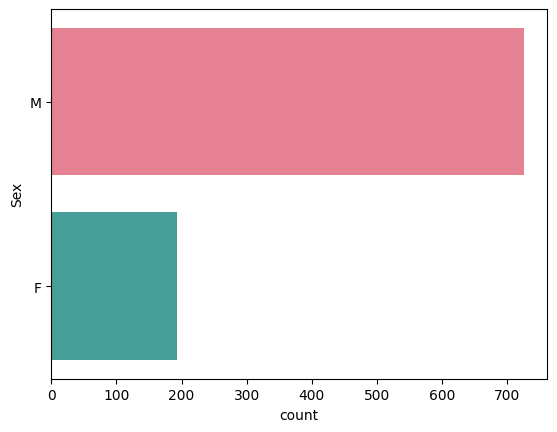

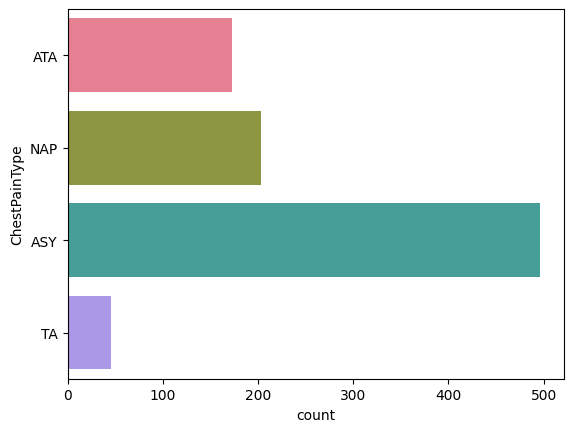

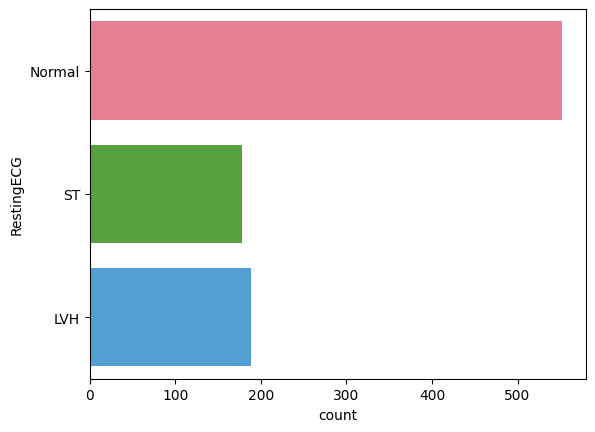

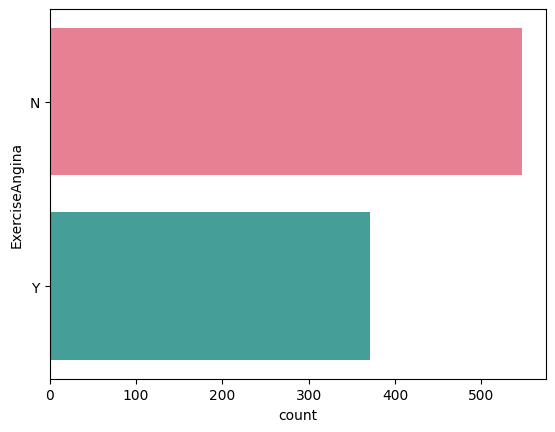

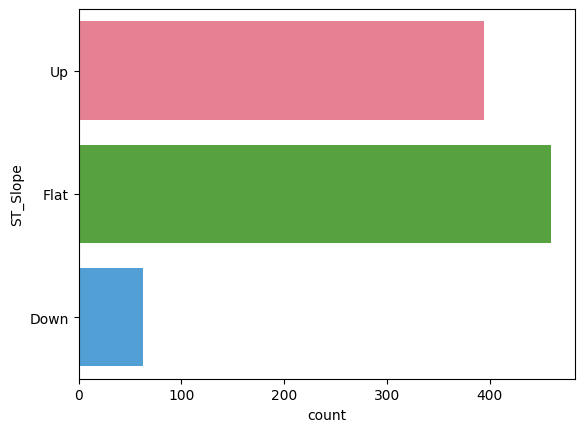

In [7]:
heartdata.visualization_cat(config_variables)

     Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak
0     40        140          289          0    172        0
1     49        160          180          0    156        1
2     37        130          283          0     98        0
3     48        138          214          0    108       15
4     54        150          195          0    122        0
..   ...        ...          ...        ...    ...      ...
913   45        110          264          0    132       12
914   68        144          193          1    141       34
915   57        130          131          0    115       12
916   57        130          236          0    174        0
917   38        138          175          0    173        0

[918 rows x 6 columns]


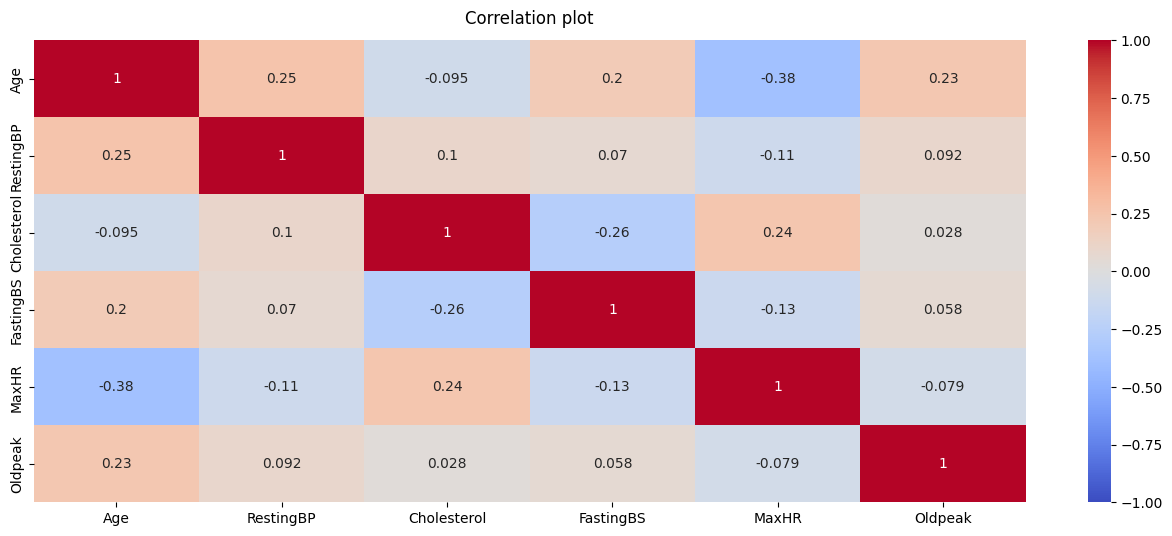

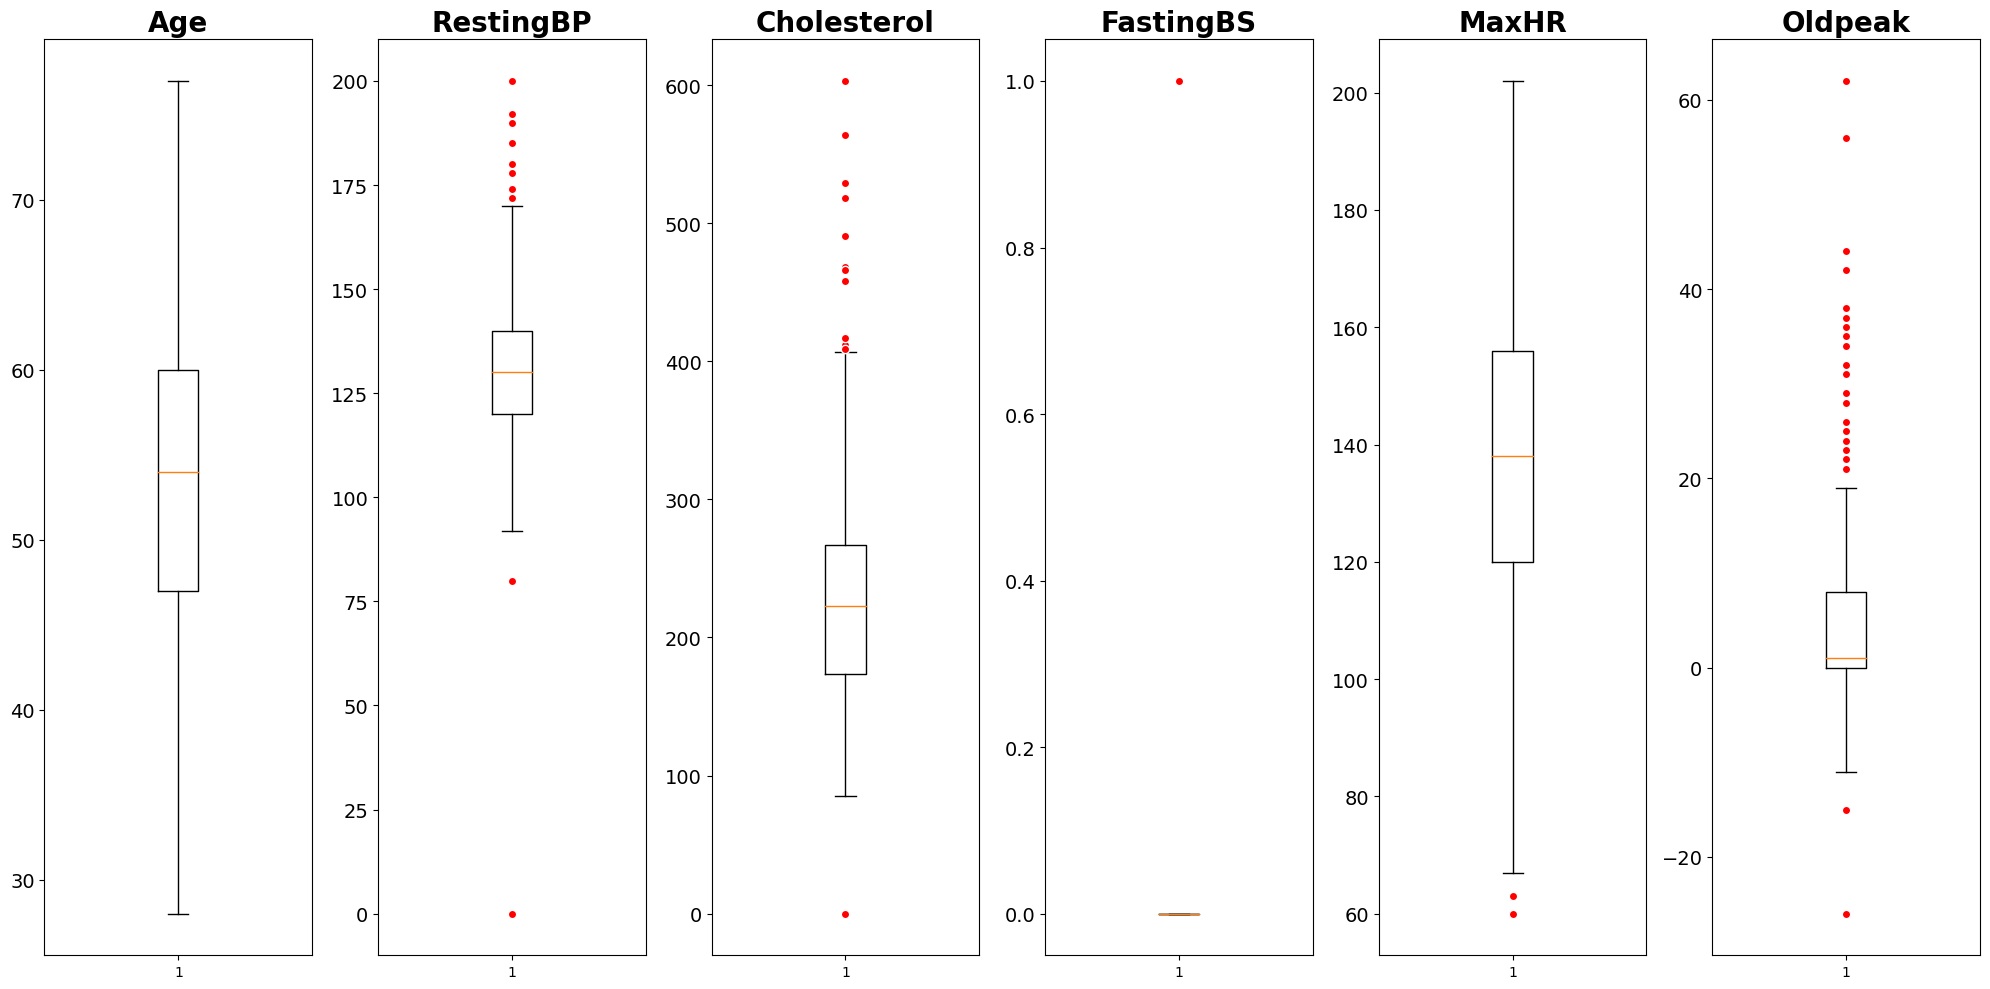

In [12]:
heartdata.visualization_num(config_variables)

In [16]:
#I should delete the first column 
heartdata.data_imputation(config_variables)


Index(['Unnamed: 0', 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'Oldpeak'],
      dtype='object')


C:\Users\arant\AppData\Local\Temp\ipykernel_12004\1809191144.py:30: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
c:\Users\arant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
